In [1]:
import pyanitools as pyt
import pyaniasetools as aat
import hdnntools as hdt
import numpy as np

import matplotlib.pyplot as plt
import aniensemblestats as ens

In [15]:
#h5files = '/home/jujuman/Research/DataReductionMethods/modelCNOSFCl/initial/cv1/testset/testset1.h5'
#h5files = '/home/jujuman/Seagate2TB/Research/ANI-DATASET/h5data/ani_data_c10test.h5'
h5files = '/home/jujuman/Research/extensibility_test_sets/gdb-10/gdb11_10_test500.h5'

#wkdir = '/home/jujuman/Research/DataReductionMethods/model6r/model-gdb_r06_comb09_1/cv4/'
#wkdir = '/home/jujuman/Research/DataReductionMethods/train_test/ANI-9.0.4_netarch7/'
#wkdir = '/home/jujuman/Research/ANI-validation/'
wkdir = '/home/jujuman/Research/DataReductionMethods/al_working_network/ANI-AL-0707.0000.0401'
cnstfile = wkdir + '/train0/rHCNOSFCl-4.6A_16-3.1A_a4-8.params'
saefile  = wkdir + '/train0/sae_wb97x-631gd.dat'

#cnstfile = wkdir + '/rHCNO-4.6A_16-3.1A_a4-8.params'
#saefile  = wkdir + '/sae_6-31gd.dat'
nnfdir   = wkdir + '/train'
Nn = 5

In [16]:
# Define the conformer cross validator class
anicv = aat.anicrossvalidationconformer(cnstfile,saefile,nnfdir,Nn,0,False)

In [17]:
adl = pyt.anidataloader(h5files)

In [18]:
Eani_t = []
Edft_t = []
for data in adl:
    X = data['coordinates']
    S = data['species']
    Edft = hdt.hatokcal*data['energies']

    #Fdft = data['forces']

    #if 'N' in S:
    Eani, Fani = anicv.compute_energy_conformations(X=X,S=S)
    Eani = np.mean(Eani,axis=0)
    idx = np.where((Edft - Edft.min() < 300.0))
    print(hdt.calculaterootmeansqrerror(Edft[idx]-Edft[idx].min(),Eani[idx]-Eani[idx].min()))
    Eani_t.append(Eani[idx]-Eani[idx].min())
    Edft_t.append(Edft[idx]-Edft[idx].min())
    #print(np.abs(-Fani[0]-hdt.hatokcal*Fdft))

Eani_t = np.concatenate(Eani_t)
Edft_t = np.concatenate(Edft_t)

3.77850568189
2.62762728122
2.98975125513
1.93895365144
0.88672284136
1.54086510736
0.768494347905
1.25146929763
1.742228578
0.873885575444
0.594557937019
0.868805861269
1.57999148486
2.14189645412
0.612891647808
4.92703845362
1.2827217876
1.09692685989
1.17962450293
0.833517199934
2.03919134464
2.02489569518
3.85196985875
1.37703454975
1.66461876083
0.75506885258
1.24461273712
0.607485357198
1.48526009668
1.17199561873
1.06797131805
2.55504280336
1.1130746758
1.03372195529
0.797669570259
1.41050062332
0.845382342514
2.27338974287
1.66500755546
1.78230659077
1.39024165743
0.97851027652
2.07469509078
1.26287958337
2.30284746587
1.24901848985
1.38210249297
1.13848172497
0.97279687715
1.49203142202
0.783462015191
0.700045355331
1.71400832572
1.79561711601
1.00654385813
1.20252167718
0.920889544517
2.79562492999
2.04063099229
2.31600847853
1.79354302191
1.51194276732
2.64226736342
2.13895029188
0.947118426591
0.988430487025
2.25509759076
1.19410796642
2.44378396494
1.24055644206
1.04452771

In [19]:
print(hdt.calculaterootmeansqrerror(Eani_t,Edft_t))

2.05748938727


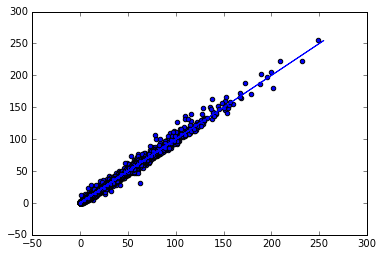

In [20]:
plt.plot(Edft_t,Edft_t)
plt.scatter(Eani_t,Edft_t)
plt.show()

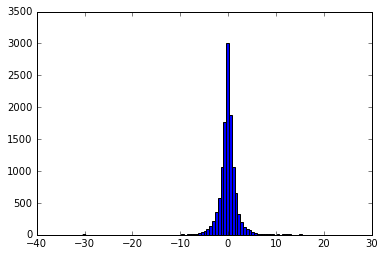

In [21]:
plt.hist(Edft_t-Eani_t,bins=100)
plt.show()